<a href="https://colab.research.google.com/github/Flower1311/mt/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Trade_Python_NN_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
import time

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Flower1311/mt/main/Test_infl.csv", sep=',')



In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 18
tf.random.set_seed(8)

In [ ]:
uni_data = data['Inflation']
uni_data.index = data['Date']
uni_data.head()

Date
20220101    0.400000
20220103    0.336269
20220105    0.371290
20220107    0.404413
20220109    0.435689
Name: Inflation, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff918571fd0>],
      dtype=object)

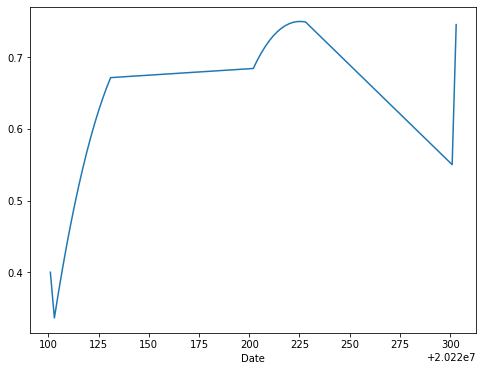

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std
print(uni_data)


[-1.23555631 -1.80172881 -1.49060978 -1.19635217 -0.91850291 -0.65663558
 -0.410306   -0.17910549  0.03739234  0.23959617  0.42790576  0.60272976
  0.76445907  0.91347568  1.05017936  1.17492547  1.28808712  1.39004632
  1.48114953  1.56175211  1.63220941  1.69285013  1.74402073  1.78604991
  1.81927527  1.84399884  1.86054933  1.86923767  1.87035703  1.86421834
  0.09701142  1.83133945]


In [ ]:
univariate_past_history = 10
univariate_future_target = 0
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target inflation to predict')
print (y_train_uni[0])

Single window of past history
[[-1.23555631]
 [-1.80172881]
 [-1.49060978]
 [-1.19635217]
 [-0.91850291]
 [-0.65663558]
 [-0.410306  ]
 [-0.17910549]
 [ 0.03739234]
 [ 0.23959617]]

 Target inflation to predict
0.42790576096391125


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

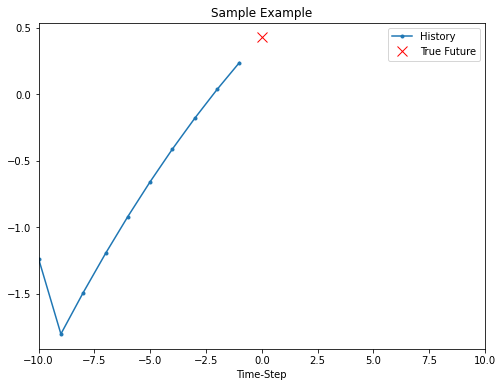

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

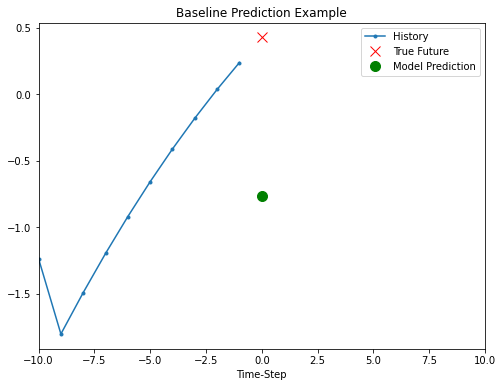

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')


In [ ]:
BATCH_SIZE = 10
BUFFER_SIZE = 30000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(4, 1)


In [ ]:
print(x_train_uni.shape)

(8, 10, 1)


In [ ]:
EVALUATION_INTERVAL =300
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Epoch 1/10
300/300 [==============================] - 5s 10ms/step - loss: 0.1266 - val_loss: 0.5244
Epoch 2/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0086 - val_loss: 0.5212
Epoch 3/10
300/300 [==============================] - 2s 8ms/step - loss: 0.0083 - val_loss: 0.5238
Epoch 4/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0081 - val_loss: 0.5258
Epoch 5/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0079 - val_loss: 0.5268
Epoch 6/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0076 - val_loss: 0.5317
Epoch 7/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0074 - val_loss: 0.5341
Epoch 8/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0073 - val_loss: 0.5367
Epoch 9/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0071 - val_loss: 0.5374
Epoch 10/10
300/300 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.544

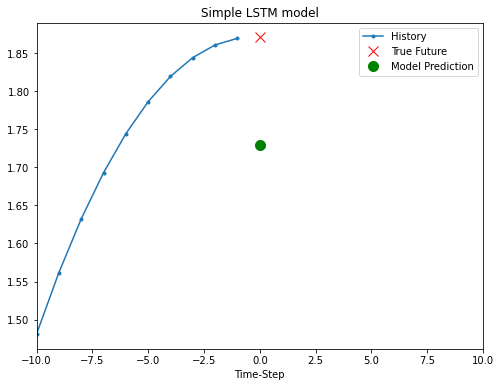

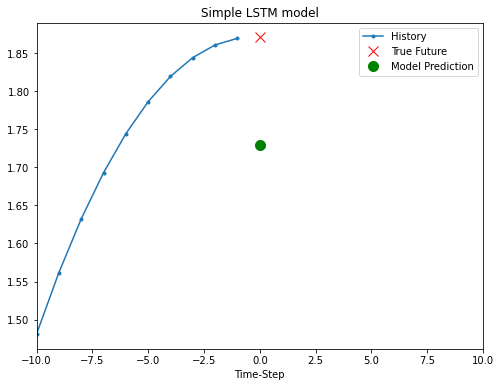

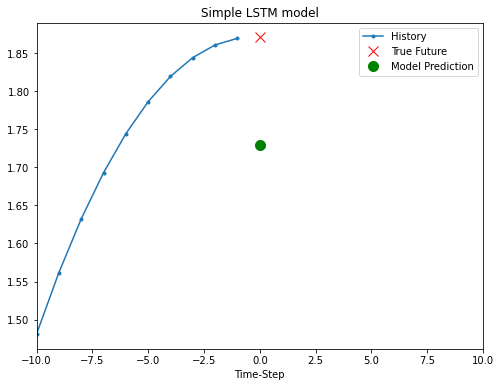

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  
  plot.show()
 

In [ ]:
actual_predictions = simple_lstm_model.predict(x)[-TRAIN_SPLIT:].mean()
actual_predictions_std= simple_lstm_model.predict(x)[-TRAIN_SPLIT:].std()
s = (simple_lstm_model.predict(x)-actual_predictions)/actual_predictions_std
print(s)


[[ 0.5295497 ]
 [ 0.58529735]
 [ 0.61636704]
 [-1.7312124 ]]
